## 20200923-181126-network-RMSprop

In [1]:
import tensorflow as tf
import numpy as np
import sys
sys.path.append('../../')
import utils.data_preprocess as preprocess
from utils.model_metrics import ModelMetric
from utils.mode_figure import ModelFigre
import datetime
from utils.model_callback import step_decay, exp_decay, MyStopTrainCallBack

In [2]:
modelmetric = ModelMetric()

In [3]:
pre = preprocess.preprocess("D:/DataSet/CICIDS2017/CSV/Wednesday-workingHours.pcap_ISCX.csv", labelColumnName='Label', depth=2)
X_train, X_test, y_train, y_test = pre.preprocessing()

In [4]:
from tensorflow.keras import layers, Input, constraints
from tensorflow.keras import Model
dos_input = Input(shape=(X_train.shape[1],))

dense = layers.Dense(256, name='nn1', kernel_constraint=constraints.MaxNorm(max_value=4))(dos_input)
activation = layers.Activation(tf.nn.relu, name='nn1_relu')(dense)
dense = layers.Dense(128, name='nn2')(activation)
drop = layers.GaussianDropout(0.5)(dense)
activation = layers.Activation(tf.nn.relu, name='nn2_relu')(dense)
dense = layers.Dense(64, name='nn3')(drop)
noise = layers.GaussianNoise(0.5)(dense)
activation = layers.Activation(tf.nn.relu, name='nn3_relu')(dense)
dense = layers.Dense(32, name='nn4')(noise)
noise = layers.GaussianNoise(0.2)(dense)
activation = layers.Activation(tf.nn.relu, name='nn4_relu')(dense)
dense = layers.Dense(16, name='nn5')(noise)
activation = layers.Activation(tf.nn.relu, name='nn5_relu')(dense)
dense = layers.Dense(8, name='nn6')(activation)
activation = layers.Activation(tf.nn.relu, name='nn6_relu')(dense)
dense = layers.Dense(2, name='nn7')(activation)
output = layers.Activation(tf.nn.softmax, name='output')(dense)

model = Model(inputs=dos_input, outputs=output)
# algorithm = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, clipvalue=0.3, momentum=0.9, epsilon=1e-07, decay= 1e-06, centered=False, name='RMSprop')
algorithm = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.99, clipvalue=0.2, nesterov=True, name='SGD')

model.compile(optimizer=algorithm, loss='binary_crossentropy', metrics=modelmetric.metric('binary_crossentropy')) # categorical_crossentropycategorical_crossentropy

In [5]:
from tensorflow.keras import callbacks
dir_name = datetime.datetime.now().strftime("ANN-%Y%m%d-%H%M%S-SGD")

logdir = os.path.join("../../tensorboard", dir_name)
tensorboard_callback = callbacks.TensorBoard(logdir, histogram_freq=1)
# lrate = callbacks.LearningRateScheduler(step_decay)
csv_log = tf.keras.callbacks.CSVLogger('../../model_record/'+dir_name+"/log", separator=',', append=False)
if not os.path.isdir('../../model_record/'+dir_name):
    os.mkdir('../../model_record/'+dir_name)
    os.mkdir('../../model_record/'+dir_name+'/model')
# stop_train = MyStopTrainCallBack()
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [6]:
import numpy as np
model_ = model.fit(X_train, y_train, epochs=40, batch_size=512, validation_split=0.3, callbacks=[tensorboard_callback, csv_log], verbose=1) # lrate

_crossentropy: 0.0565 - val_loss: 0.0484 - val_tp: 142949.0000 - val_fp: 2247.0000 - val_tn: 142949.0000 - val_fn: 2247.0000 - val_acc: 0.4990 - val_precision: 0.9845 - val_recall: 0.9845 - val_auc: 0.9982 - val_binary_accuracy: 0.9845 - val_binary_crossentropy: 0.0484
Epoch 3/40
662/662 [==============================] - 6s 10ms/step - loss: 0.0481 - tp: 333072.0000 - fp: 5716.0000 - tn: 333072.0000 - fn: 5716.0000 - acc: 0.4461 - precision: 0.9831 - recall: 0.9831 - auc: 0.9983 - binary_accuracy: 0.9831 - binary_crossentropy: 0.0481 - val_loss: 0.0478 - val_tp: 142850.0000 - val_fp: 2346.0000 - val_tn: 142850.0000 - val_fn: 2346.0000 - val_acc: 0.4688 - val_precision: 0.9838 - val_recall: 0.9838 - val_auc: 0.9984 - val_binary_accuracy: 0.9838 - val_binary_crossentropy: 0.0478
Epoch 4/40
662/662 [==============================] - 6s 10ms/step - loss: 0.0457 - tp: 333382.0000 - fp: 5406.0000 - tn: 333382.0000 - fn: 5406.0000 - acc: 0.4189 - precision: 0.9840 - recall: 0.9840 - auc: 0.9

In [7]:
results  = model.evaluate(X_test, y_test, verbose=1)
modelmetric.getTrainMetricValue(model, results)

6482/6482 [==============================] - 33s 5ms/step - loss: 0.0381 - tp: 204700.0000 - fp: 2722.0000 - tn: 204700.0000 - fn: 2722.0000 - acc: 0.4912 - precision: 0.9869 - recall: 0.9869 - auc: 0.9990 - binary_accuracy: 0.9869 - binary_crossentropy: 0.0381
loss :  0.03813507407903671
tp :  204700.0
fp :  2722.0
tn :  204700.0
fn :  2722.0
acc :  0.4912063181400299
precision :  0.9868770241737366
recall :  0.9868770241737366
auc :  0.9989767074584961
binary_accuracy :  0.9868770241737366
binary_crossentropy :  0.03813507407903671


In [8]:
y_pred = model.predict(X_test)
y_class = np.argmax(y_pred, axis=1)
y_label = np.argmax(y_test, axis=1)
modelmetric.confusion_matrix(y_label, y_class)
modelmetric.eva_metric(y_label, y_class)

TrueNegatives result:  129128.0
TruePositives result:  75572.0
FalseNegatives result:  73.0
FalsePositives result:  2649.0
Recall result:  0.99903494
Precision result:  0.9661344


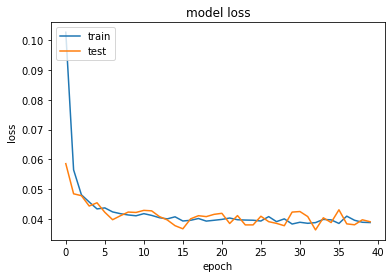

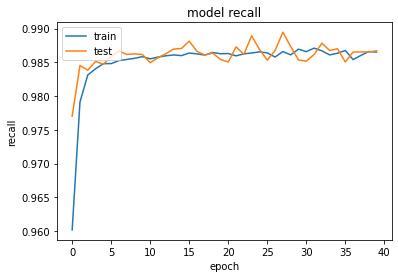

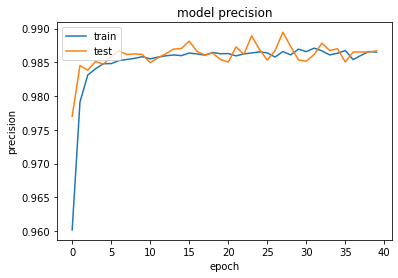

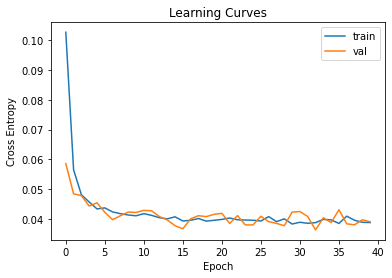

In [9]:
mf = ModelFigre("../../model_record", dir_name, model_)
mf.loss_graph()
mf.recall_graph()
mf.precision_graph()
mf.cross_entropy_graph()
# fig.save_model(net,dir_name)

In [10]:
mf.lr_graph()

KeyError: 'lr'

In [11]:
model.save('../../model_record/'+dir_name+'/model/model.h5')

In [12]:
# mf.save_model()